# Llama Experiments Report
The following is the report from the experiments performed on the llama finetuning process. The base model for the experiments is `llama-3.2-1b`.

In [1]:
import wandb
import matplotlib.pyplot as plt
import numpy as np

In [29]:
from typing import List


# again, credits to GustawB
def plot_series(series: List[np.ndarray], names, title, log_scale=False, xs = None):
    if xs is None:
        xs = [None] * len(series)
    plt.figure(figsize=(10, 5))
    if log_scale:
        plt.yscale('log')
    for s, n, x in zip(series, names, xs):
        if x is None:
            plt.plot(s, label=n)
        else:
            plt.plot(x, s, label=n)

    plt.xlabel("Step")
    plt.ylabel("time")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()


def interpolate_nans(series):
    mask = np.isnan(series)
    series[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), series[~mask])
    return series


def filter_nans(series):
    mask = np.isnan(series)
    return series[~mask]


wandb.login()
api = wandb.Api()

## Baseline finetune
This experiment involves fine tuning llama on full dataset consisting of apps: \[rewe, rossmann, dm, lidl\]. The evaluation is performed on selected parts of these datasets, and test evaluation is performed on the apps edeka and penny

In [24]:
runs = api.runs(f"{wandb.Api().default_entity}/llama-finetune-complete")

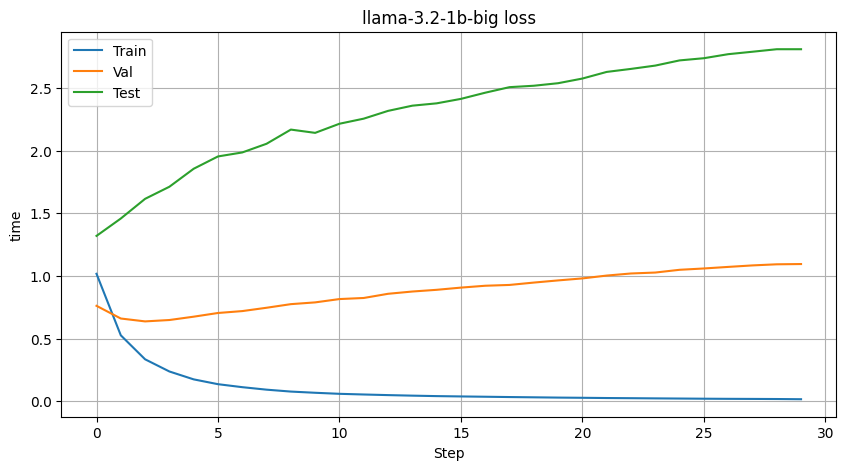

In [25]:
for run in runs:
    train_loss = run.history()["train/loss"].to_numpy()
    val_loss = run.history()["eval/eval_loss"].to_numpy()
    test_loss = run.history()["eval/test_loss"].to_numpy()
    plot_series([filter_nans(train_loss), filter_nans(val_loss), filter_nans(test_loss)], ["Train", "Val", "Test"], title=f"{run.name} loss")

It looks like the model is overfitting. Additionally, more than 5 epochs results in model's not being able to generalize even to the data from the same app

## Appwise training
In this experiment we evaluate the models finetuned on the data from single app on both evaluation part of this app's dataset and penny and edeka

In [30]:
runs = api.runs(f"{wandb.Api().default_entity}/llama-finetune-complete-wth-short-ft")

llama-3.2-1b-big-appwise-rewe 44 14
llama-3.2-1b-big-appwise-lidl 16 5
llama-3.2-1b-big-appwise-dm 16 5
llama-3.2-1b-big-appwise-rossmann 16 5


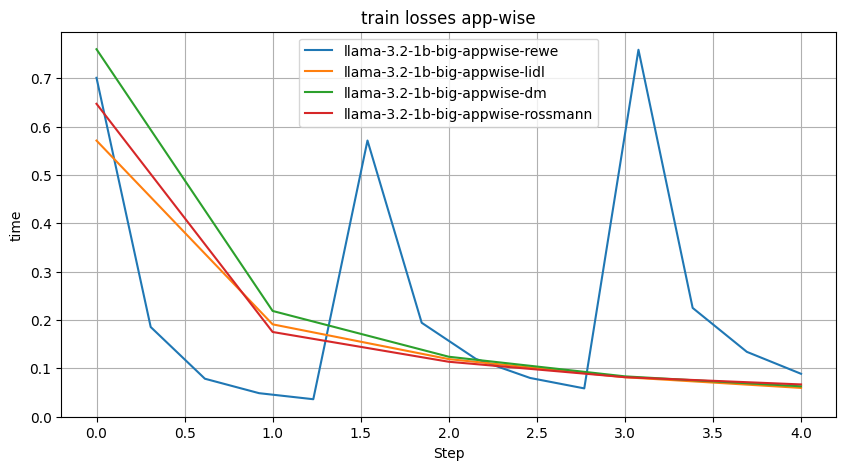

In [34]:
train_losses = {}
for run in runs:
    train_loss = run.history()["train/loss"].to_numpy()
    train_losses[run.name] = filter_nans(train_loss)
    print(run.name, len(train_loss), len(train_losses[run.name]))
plot_series(train_losses.values(), train_losses.keys(), title=f"train losses app-wise", xs=[np.arange(14) / (13 / 4), None, None, None])

There is instability in fine-tuning on REWE. besides that, every app reaches similar train accuracy

llama-3.2-1b-big-appwise-rewe 44 14
llama-3.2-1b-big-appwise-lidl 16 5
llama-3.2-1b-big-appwise-dm 16 5
llama-3.2-1b-big-appwise-rossmann 16 5


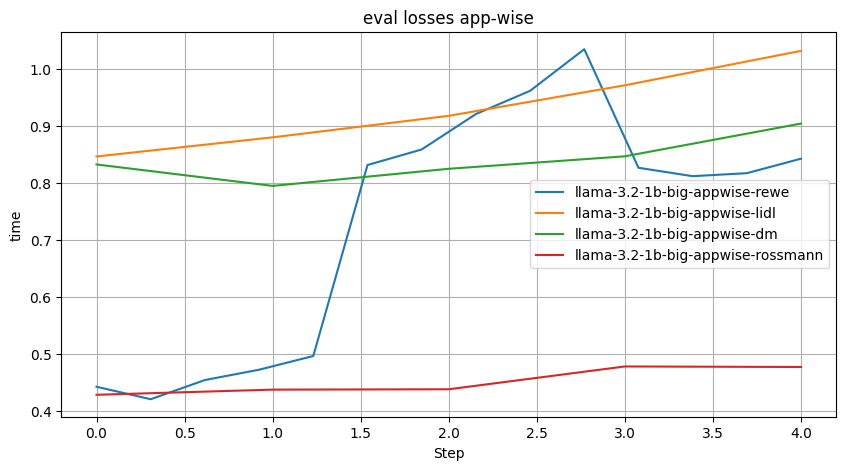

In [36]:
eval_losses = {}
for run in runs:
    eval_loss = run.history()["eval/eval_loss"].to_numpy()
    eval_losses[run.name] = filter_nans(eval_loss)
    print(run.name, len(eval_loss), len(eval_losses[run.name]))
plot_series(eval_losses.values(), eval_losses.keys(), title=f"eval losses app-wise", xs=[np.arange(14) / (13 / 4), None, None, None])

The low start value of eval loss and slight growth afterwards suggests that we could lower the epoch number even further.

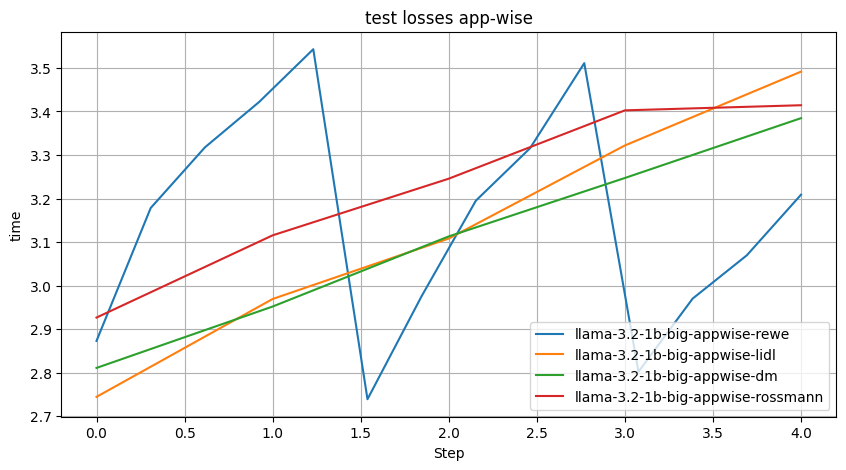

In [37]:
test_losses = {}
for run in runs:
    test_loss = run.history()["eval/test_loss"].to_numpy()
    test_losses[run.name] = filter_nans(test_loss)
plot_series(test_losses.values(), test_losses.keys(), title=f"test losses app-wise", xs=[np.arange(14) / (13 / 4), None, None, None])

Again, we see rather significant instability in rewe results. besides that, model is less able to generalize than it was when trained on these apps combined

## Progressive finetune
This experiment aims in measuring how fine tuning the model that is already adjusted to some subset of apps affects its performance. I have tested different amounts of data used for the subsequent fine-tunings. By the `inc`, I will refer to the amount of the data from the new app that is added to the dataset at each step.
### total ft
In this scenario the number of apps included in fine-tuning is increased in each step
#### Initial ft (on rewe)
For the reference, these are the results of fine tuning the model that was performed on the data from REWE app. The models were later utilized for finetunings on extended app sets. Note that this initial finetuning ds size is unaffected by the `inc` value. However, after this first fine-tuning, dataset is reduced to `inc` samples to provide balance between apps

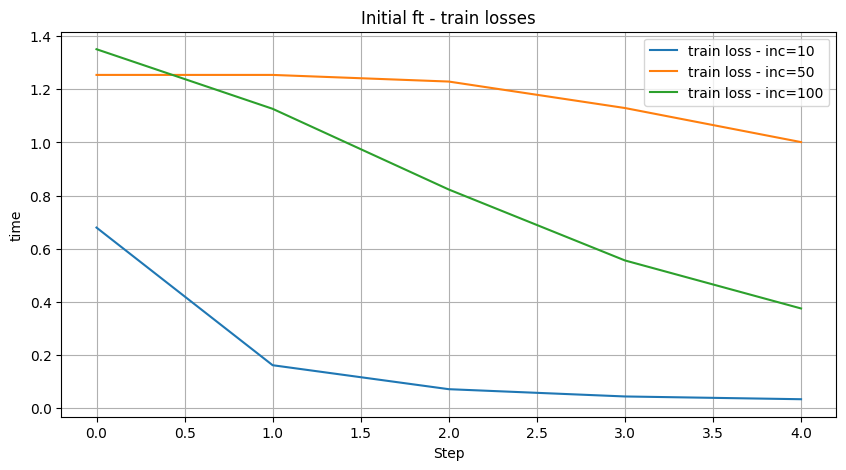

In [40]:
runs = api.runs(f"{wandb.Api().default_entity}/llama-finetune-complete-wth-progressive")
series = {}
for run in runs:
    if 'rewe' in run.name:
        increment = run.name.split('-')[-2]
        train_loss = run.history()["train/loss"].to_numpy()
        series[increment] = filter_nans(train_loss)
plot_series(series.values(), [f"train loss - inc={k}" for k in series.keys()], "Initial ft - train losses")

The performed fine-tunes were conducted on the same dataset with the same number of epochs - yet they resulted in diverging train losses. I have double-checked the code, but it seems to be correct

#### Eval losses
The evaluation losses are computed on the datasets relevant to the train dataset at each stage. That means, if at some point we are adding an app to the train dataset, the eval dataset is enchanced too.

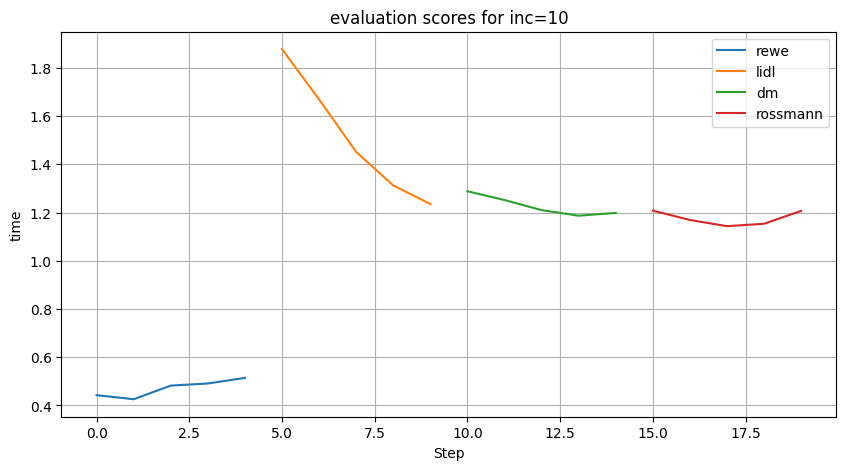

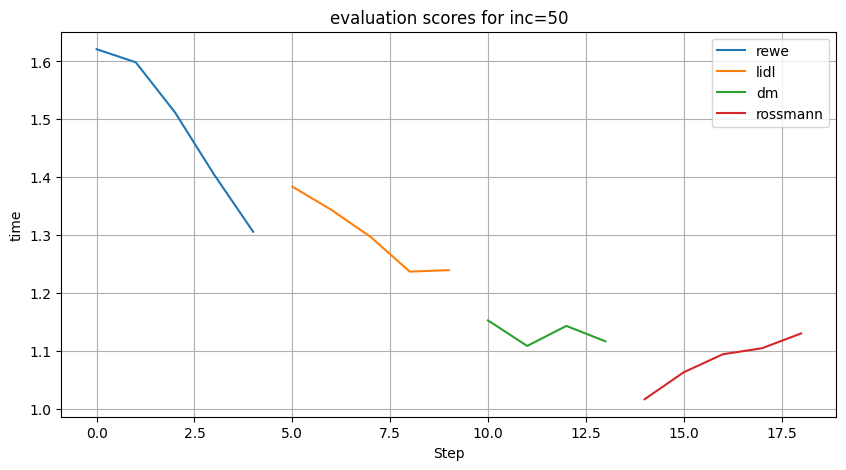

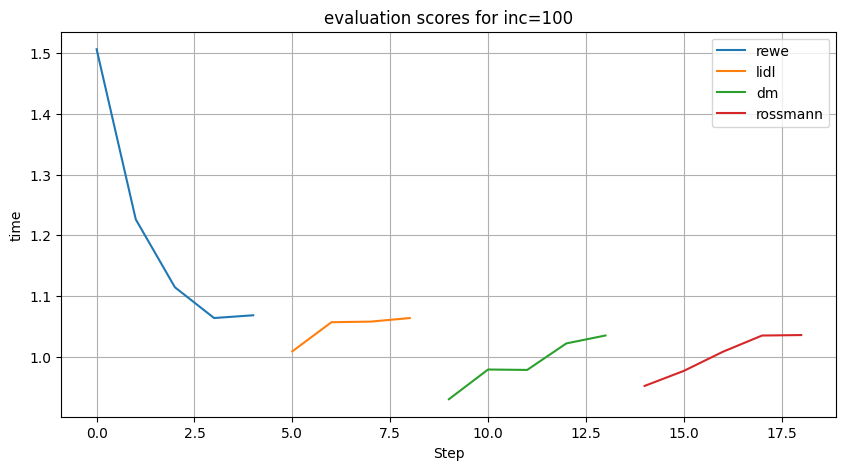

In [44]:
order = ['rewe', 'lidl', 'dm', 'rossmann']
for inc in [10, 50, 100]:
    combined = [None, None, None, None]
    for run in runs:
        if int(run.name.split('-')[-2]) == inc:
            combined[order.index(run.name.split('-')[-1])] = filter_nans(run.history()['eval/eval_loss'])
    shifts = [0]
    for series in combined[:-1]:
        shifts.append(shifts[-1] + len(series))
    plot_series(
        combined,
        order,
        f"evaluation scores for {inc=}",
        xs = [
            sft + np.arange(len(series)) for sft, series in zip(shifts, combined)
        ]
    )

We see that with `inc=100` we reach the value close to the one from full finetuning.

#### Test scores
The test scores here are computed on the data from penny and edeka.

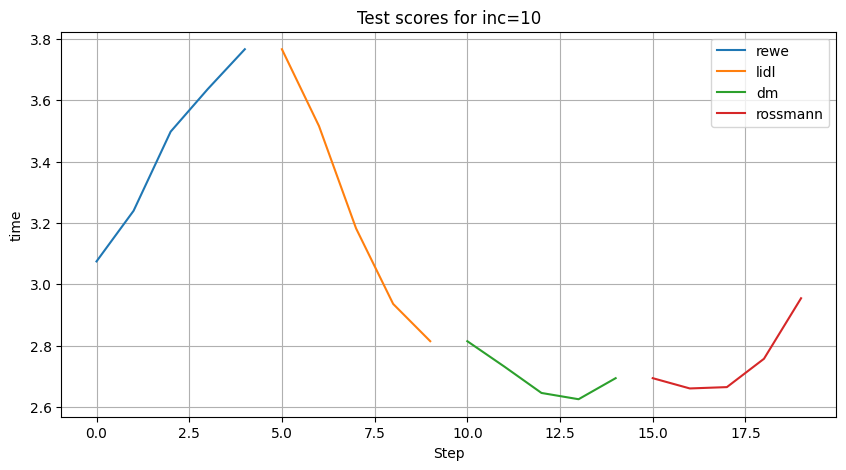

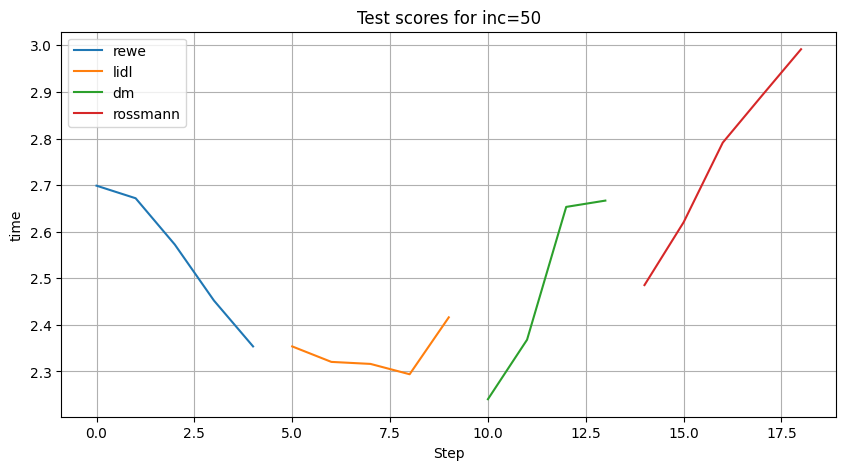

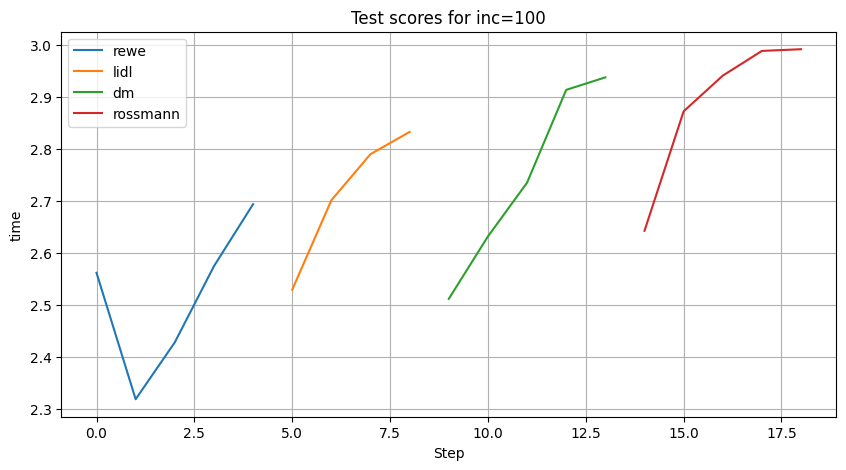

In [43]:
order = ['rewe', 'lidl', 'dm', 'rossmann']
for inc in [10, 50, 100]:
    combined = [None, None, None, None]
    for run in runs:
        if int(run.name.split('-')[-2]) == inc:
            combined[order.index(run.name.split('-')[-1])] = filter_nans(run.history()['eval/test_loss'])
    shifts = [0]
    for series in combined[:-1]:
        shifts.append(shifts[-1] + len(series))
    plot_series(
        combined,
        order,
        f"Test scores for {inc=}",
        xs = [
            sft + np.arange(len(series)) for sft, series in zip(shifts, combined)
        ]
    )

### Partial ft
In this scenario we replace dataset with the data from the new app at each step.
The evaluation data is derived from the app that is currently the source of data, while the test data comes from all the previous apps combined.
#### Initial train scores

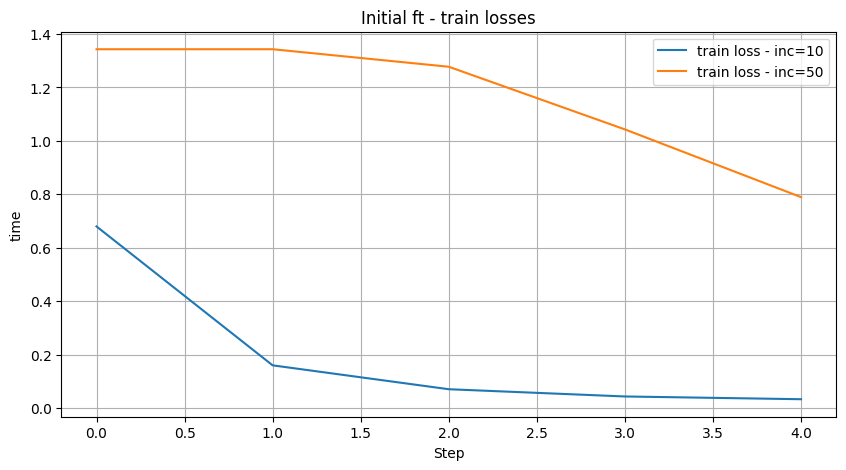

In [46]:
runs = api.runs(f"{wandb.Api().default_entity}/llama-finetune-complete-wth-progressive-sep")
series = {}
for run in runs:
    if run.name[-2:] == '-r':
        increment = run.name.split('-')[-2]
        train_loss = run.history()["train/loss"].to_numpy()
        series[increment] = filter_nans(train_loss)
plot_series(series.values(), [f"train loss - inc={k}" for k in series.keys()], "Initial ft - train losses")

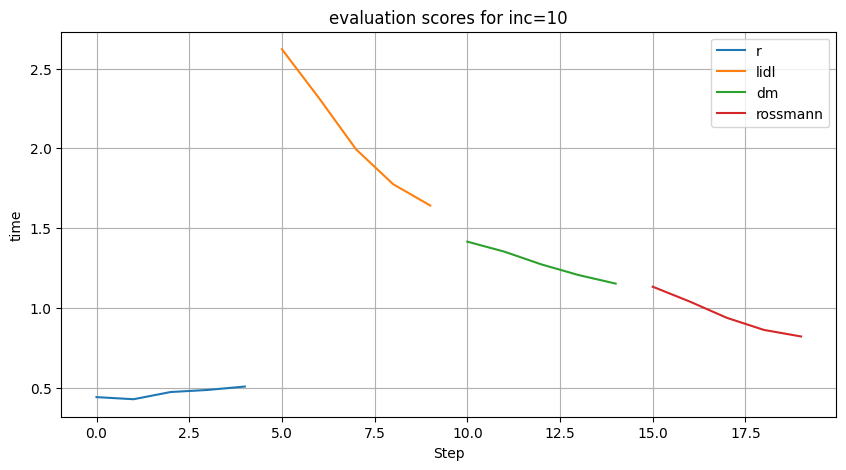

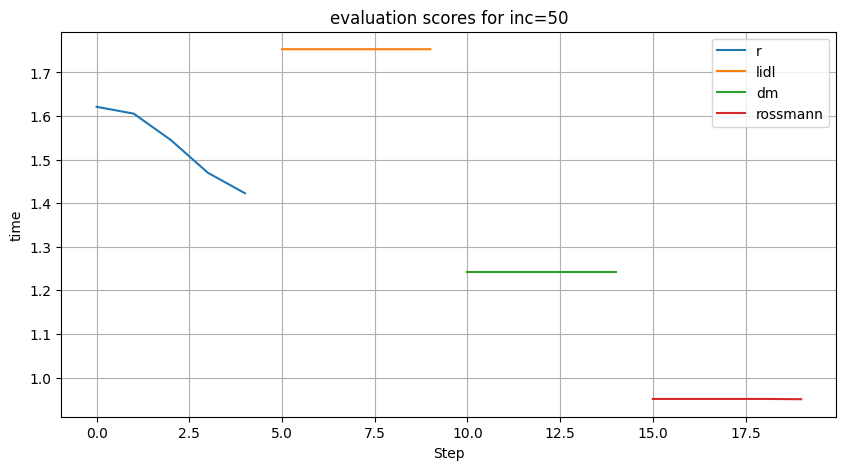

In [48]:
order = ['r', 'lidl', 'dm', 'rossmann']
for inc in [10, 50]:
    combined = [None, None, None, None]
    for run in runs:
        if int(run.name.split('-')[-2]) == inc:
            combined[order.index(run.name.split('-')[-1])] = filter_nans(run.history()['eval/eval_loss'])
    shifts = [0]
    for series in combined[:-1]:
        shifts.append(shifts[-1] + len(series))
    plot_series(
        combined,
        order,
        f"evaluation scores for {inc=}",
        xs = [
            sft + np.arange(len(series)) for sft, series in zip(shifts, combined)
        ]
    )

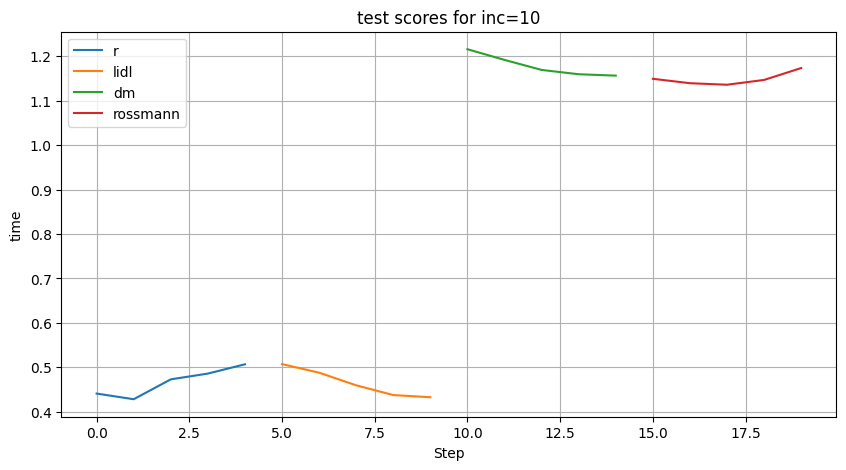

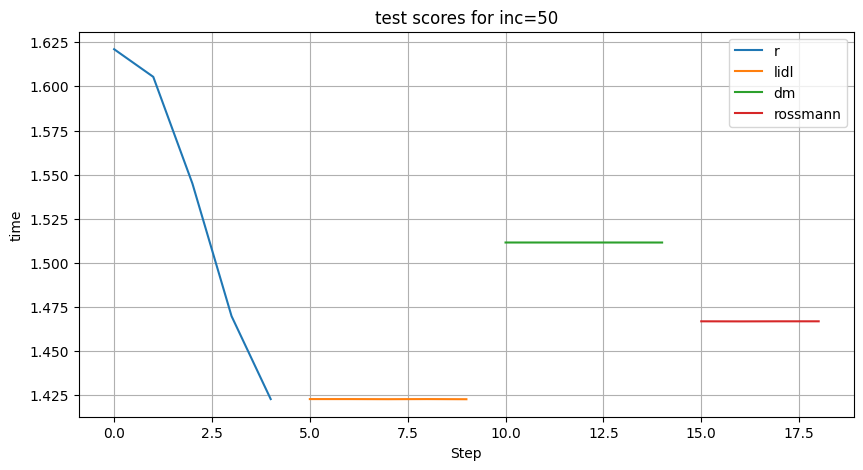

In [52]:
order = ['r', 'lidl', 'dm', 'rossmann']
for inc in [10, 50]:
    combined = [None, None, None, None]
    for run in runs:
        if int(run.name.split('-')[-2]) == inc:
            combined[order.index(run.name.split('-')[-1])] = filter_nans(run.history()['eval/test_loss'])
    shifts = [0]
    for series in combined[:-1]:
        shifts.append(shifts[-1] + len(series))
    plot_series(
        combined,
        order,
        f"test scores for {inc=}",
        xs = [
            sft + np.arange(len(series)) for sft, series in zip(shifts, combined)
        ]
    )

We see that in general model seems to remember the knowledge from the previous apps